# Testing the Statistical Analysis
## Using some of the agents as fake human reviewers.
- Load one or more ReviewSets
- For each Reviewer, gather the reviews and run create_ranking_vector
- Plot the Reviewers and the (fake) human reviewers
- Produce the heatmap comparing the reviewers
- [next - significance analysis]
## Plan:
- Create 5 AnalysisPlans -> AnalysisRuns, each with 5 Hypotheses
    - In order to run faster and use smaller LLMs, 
        - Make 5 small Datasets
            - Use the data for assemblies of ~10 genes, review what Laura sent
        - Make 5 Analysts
            - brief prompts
            - LLM:
                - Llama 3.1 70b
                - Gemini Flash
                - Mixtral
                - Haiku
                - GPT-40-mini
        - the Hypothesis text brief - so that the Reviewers can also be fast.
- Create 6 Reviewers
    - Same LLMs plus Llama 3.1 7b
    - Three are fake humans: their names begin with H.
    - Three are Agents: their names begin with R.
    - Key challenge: correct formatting of rankings and summary review
- For each AnalysisPlan, create 1 ReviewPlan using the 6 Reviewers




### Set up parent directory and db connection

In [1]:
import sys
import os

# Add the parent directory of the current script to the Python path
cwd = os.getcwd()
dirname = os.path.dirname(cwd)
print(cwd)
print(dirname)
sys.path.append(dirname)

print(sys.path)

/Users/idekeradmin/Dropbox/GitHub/agent_evaluation/notebooks
/Users/idekeradmin/Dropbox/GitHub/agent_evaluation
['/Users/idekeradmin/Dropbox/GitHub/agent_evaluation/notebooks', '/opt/anaconda3/lib/python311.zip', '/opt/anaconda3/lib/python3.11', '/opt/anaconda3/lib/python3.11/lib-dynload', '', '/Users/idekeradmin/.local/lib/python3.11/site-packages', '/opt/anaconda3/lib/python3.11/site-packages', '/opt/anaconda3/lib/python3.11/site-packages/aeosa', '/Users/idekeradmin/Dropbox/GitHub/agent_evaluation']


In [2]:
from models.analysis_plan import AnalysisPlan
from services.analysisrunner import AnalysisRunner
from models.review_plan import ReviewPlan
from services.reviewrunner import ReviewRunner
from app.sqlite_database import SqliteDatabase
from app.config import load_database_config

# Load the db connection details
# db_type, uri, user, password = load_database_config(path='~/ae_config/test_config.ini')
# self.db = Database(uri, db_type, user, password)

_, database_uri, _, _ = load_database_config()
db = SqliteDatabase(database_uri)

## Generate AnalysisRuns
### Not doing this, change cell back to code if needed

analysis_plan_ids = [p1, p2, p3]
analysis_runs = []
for ap_id in analysis_plan_ids:
    analysis_plan = AnalysisPlan.load(db, ap_id)
    analysis_run = analysis_plan.generate_analysis_run()
    analysis_runs.append(analysis_run)

for analysis_run in analysis_runs:
    runner = AnalysisRunner(db, analysis_run.object_id)
    result = runner.run()



## Load the ReviewPlans, generate the ReviewSets
### Not doing this, change cell back to code if needed

review_plan_ids = ["review_plan_ad5c1fe8-dc76-4940-a938-bdfbd569f42d"]
review_sets = []
for review_plan_id in review_plan_ids:
    review_plan = ReviewPlan.load(db, review_plan_id)
    # Generate an empty ReviewSet from the ReviewPlan
    review_set = review_plan.generate_review_set()
    review_sets.append(review_set)

review_sets[0]

## Run the ReviewSets
### Not doing this, change cell back to code if needed
Populate the ReviewSets with Reviews

for review_set in review_sets:
    # Run the ReviewSet using a ReviewRunner
    runner = ReviewRunner(db, review_set.object_id)
    result = runner.run()

review_sets[0]

## Generate the Reviewer judgment vectors from the Reviews in the ReviewSets
The vectors correspond to the given ordered list of ReviewSets. They are not comparable otherwise.

We create a datastructure in which each Reviewer is associated with its judgment vector

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from typing import Dict, Tuple
from itertools import combinations



In [4]:
from models.review import Review
from itertools import combinations
import json
import numpy as np


def get_review(db, review_set, reviewer_id):
    for review_id in review_set.review_ids:
        review = Review.load(db, review_id)
        if review.analyst_id == reviewer_id:
            return review
    raise ValueError("Reviewer not in ReviewSet")

def create_review_judgment_vector(db, review_set=None, reviewer_id=None):
    """
    Create a judgment vector for the Review 
    belonging to the Reviewer in the ReviewSet

    Each ReviewSet is the result of one or more Reviewers judging
    (assigning a partial ranking) the Hypothesis objects in an AnalysisRun, 
    as specified in the corresponding ReviewPlan

    Each Review in the ReviewSet contains a partial ranking for each Hypothesis
    in the Review. TODO: format example. There is one Review per Reviewer.
    
    The Hypotheses in the Review are identified according to their order in the 
    AnalysisRun, which is in turn specified by their order in the AnalysisPlan

    The vector is in N dimensions in the judgment space where
    N is the number of unique hypothesis vs. hypothesis comparisons.

    Each comparison is represented as 1 | 0 | -1 based on: 
        A > B -> 1  (prefer A)
        A = B -> 0  (no preference)
        A < B -> -1 (prefer B)
    
    :param review_set: ReviewSet object
    :return: NumPy array representing the judgment vector
    """
    review = get_review(db, review_set, reviewer_id)

    ranking_data = json.loads(review.ranking_data)

    N = len(ranking_data["rankings"])  # Number of Hypothesis objects in the ReviewSet

    rankings = np.zeros(N, dtype=int) 
    for hypothesis_id, ranking in ranking_data["rankings"].items():
        order = int(ranking["order"])
        stars = int(ranking["stars"])
        rankings[order - 1] = stars
    
    # Create a vector long enough to hold the unique A-B comparisons,
    # not including self comparisons
    review_judgment_vector_length = (N * (N - 1) // 2)
    review_judgment_vector = np.zeros(review_judgment_vector_length, dtype=np.int8)
    
    idx = 0
    for i, j in combinations(range(N), 2):
        if rankings[i] < rankings[j]:
            review_judgment_vector[idx] = -1
        elif rankings[i] > rankings[j]:
            review_judgment_vector[idx] = 1
        # If the hypotheses are tied, the value remains 0
        idx += 1
    
    return review_judgment_vector


In [5]:

def create_judgment_vector(db, review_sets=None, reviewer_id=None):
    # For a each ReviewSet, create a judgment
    # vector for the specified Reviewer
    #
    # Each judgement_vector represents coordinates
    # in a separate set of dimensions in the
    # judgment space. 
    #
    # We can therefore create a merged vector
    # by simple concatenation.
    #
    # NOTE
    # The judgment vectors for the reviewers are
    # comparable ONLY if the ReviewSets 
    # have exactly the same Reviewers. Otherwise,
    # the vectors will be of different lengths
    # for different reviewers and the A-B
    # comparisons will not align.
    judgment_vector_list = []
    review_jvecs = {}
    for review_set in review_sets:
        review_jvec = create_review_judgment_vector(db, review_set=review_set, reviewer_id=reviewer_id)
        judgment_vector_list.append(review_jvec)
        review_jvecs[reviewer_id] = review_jvec
    return np.concatenate(judgment_vector_list), review_jvecs


In [6]:
#from app.analysis import create_review_judgment_vector, create_judgment_vector
from models.analyst import Analyst
from models.review_set import ReviewSet

review_set_ids = ["review_set_718d6273-a001-4576-9beb-d2bc33f661df"]
review_sets = []
for review_set_id in review_set_ids:
    review_set = ReviewSet.load(db, review_set_id)
    review_sets.append(review_set)

reviewer_judgment_vectors = {}

# We get the ReviewPlan for the first ReviewSet so that we can get the list of Reviewers
# The list must be the same for all review sets - each Reviewer must see the same ReviewSets 
# TODO: add error checking to be sure that the Reviewers match across the ReviewSets
review_plan = ReviewPlan.load(db, review_sets[0].review_plan_id)
for reviewer_id in review_plan.analyst_ids:
    print(f'making jvec for reviewer: {reviewer_id}')
    judgment_vector, review_jvecs = create_judgment_vector(db, review_sets=review_sets, reviewer_id=reviewer_id)
    print(f"review jvecs: {review_jvecs}")
    reviewer_judgment_vectors[reviewer_id] = {"judgment_vector": judgment_vector,
                                               "review_judgment_vectors": review_jvecs}
    

reviewer_judgment_vectors

making jvec for reviewer: analyst_8148fd22-bdd8-4bda-910d-f7301f98a64d
review jvecs: {'analyst_8148fd22-bdd8-4bda-910d-f7301f98a64d': array([1, 1, 0], dtype=int8)}
making jvec for reviewer: analyst_84a2a6a3-ba70-4c9e-98ce-416aaaf5fad1
review jvecs: {'analyst_84a2a6a3-ba70-4c9e-98ce-416aaaf5fad1': array([-1,  1,  1], dtype=int8)}


{'analyst_8148fd22-bdd8-4bda-910d-f7301f98a64d': {'judgment_vector': array([1, 1, 0], dtype=int8),
  'review_judgment_vectors': {'analyst_8148fd22-bdd8-4bda-910d-f7301f98a64d': array([1, 1, 0], dtype=int8)}},
 'analyst_84a2a6a3-ba70-4c9e-98ce-416aaaf5fad1': {'judgment_vector': array([-1,  1,  1], dtype=int8),
  'review_judgment_vectors': {'analyst_84a2a6a3-ba70-4c9e-98ce-416aaaf5fad1': array([-1,  1,  1], dtype=int8)}}}

## Plot the judgment vectors
 - Label the points with the Reviewer names
 - The Reviewer names are prefixed with "H.", which is stripped off before labeling
 - Agents in red squares, Humans in blue circles.

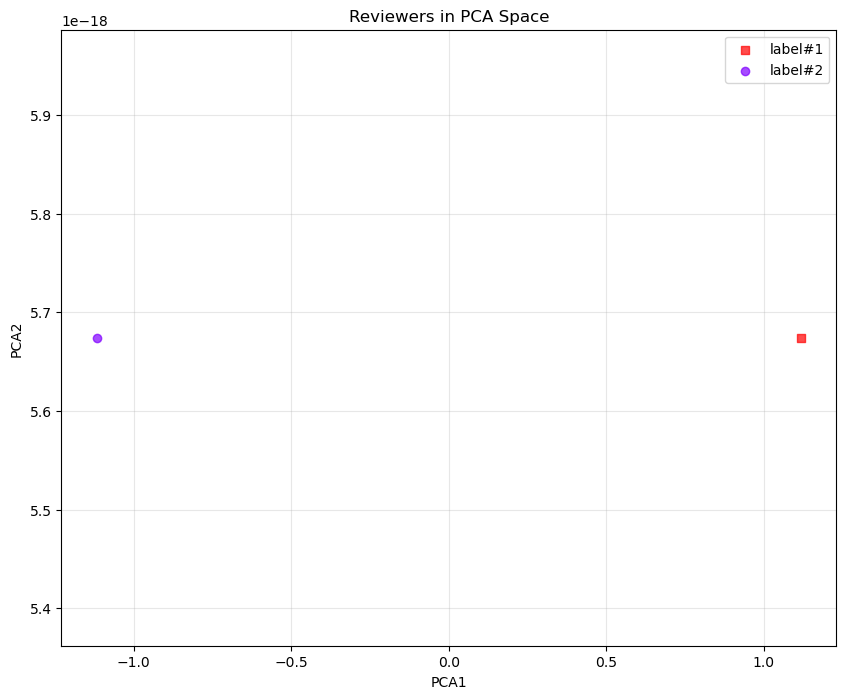

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from typing import Dict, Tuple

def visualize_judgment_vectors(reviewer_data: Dict[str, Dict], 
                               plot_type: str = 'PCA', 
                               n_components: int = 2,
                               random_state: int = 42,
                               figsize: Tuple[int, int] = (10, 8)):
    """
    Visualize multiple reviewers in judgment space.
    
    :param reviewer_data: Dictionary of reviewer data
    :param plot_type: Type of plot ('PCA', 'UMAP', or 'TSNE')
    :param n_components: Number of components for dimensionality reduction
    :param random_state: Random state for reproducibility
    :param figsize: Figure size
    """
    # Extract judgment vectors and labels
    judgment_vectors = []
    labels = []
    n = 1
    for reviewer_id, data in reviewer_data.items():
        judgment_vectors.append(data['judgment_vector'])
        if "label" in data and data['label'] is not None:
            labels.append(data['label'])
        else:
            labels.append(f'label#{str(n)}')
            n += 1

    # Convert to numpy array
    all_reviewers = np.vstack(judgment_vectors)

    # Determine the number of components
    n_samples, n_features = all_reviewers.shape
    n_components = min(n_components, n_samples, n_features)
    
    # Perform dimensionality reduction
    if plot_type == 'PCA':
        reducer = PCA(n_components=n_components, random_state=random_state)
    elif plot_type == 'UMAP':
        reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    elif plot_type == 'TSNE':
        reducer = TSNE(n_components=n_components, random_state=random_state)
    else:
        raise ValueError("Invalid plot_type. Choose 'PCA', 'UMAP', or 'TSNE'.")
    
    try:
        reduced_data = reducer.fit_transform(all_reviewers)
    except ValueError as e:
        print(f"Error in dimensionality reduction: {e}")
        print(f"Number of reviewers: {n_samples}, Number of features: {n_features}")
        return
    
    # Plotting
    plt.figure(figsize=figsize)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(set(labels))))
    color_dict = {label: color for label, color in zip(set(labels), colors)}
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'd', '|', '_']
    marker_dict = {label: marker for label, marker in zip(set(labels), markers)}
    
    for i, (x, y) in enumerate(reduced_data):
        label = labels[i]
        plt.scatter(x, y, 
                    c=[color_dict[label]], 
                    marker=marker_dict[label], 
                    label=label if label not in plt.gca().get_legend_handles_labels()[1] else "",
                    alpha=0.7)
    
    plt.title(f"Reviewers in {plot_type} Space")
    plt.xlabel(f"{plot_type}1")
    plt.ylabel(f"{plot_type}2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


visualize_judgment_vectors(reviewer_judgment_vectors)

## Create the Reviewer similarity heatmap
 - higher similarity is more red

In [16]:

import seaborn as sns

"""

{'analyst_8148fd22-bdd8-4bda-910d-f7301f98a64d': {'judgment_vector': array([1, 1, 0], dtype=int8),
  'review_judgment_vectors': {'analyst_8148fd22-bdd8-4bda-910d-f7301f98a64d': array([1, 1, 0], dtype=int8)}},
 'analyst_84a2a6a3-ba70-4c9e-98ce-416aaaf5fad1': {'judgment_vector': array([-1,  1,  1], dtype=int8),
  'review_judgment_vectors': {'analyst_84a2a6a3-ba70-4c9e-98ce-416aaaf5fad1': array([-1,  1,  1], dtype=int8)}}}

"""

def reviewer_similarity_heatmap(db, reviewer_judgment_vectors, metric='cosine', method='average', figsize=(12, 10)):
    """
    Create a similarity heatmap for judgment vectors with clustering.
    
    :param reviewer_judgment_vectors: dict where the keys are reviewer ids and the values are numpy vectors
    :param judge_labels: List of labels for each reviewer
    :param metric: Distance metric for similarity (default: 'cosine')
    :param method: Linkage method for hierarchical clustering (default: 'average')
    :param figsize: Figure size (width, height) in inches
    """

    # 2D array where each row is a reviewer's vector
    judgment_vectors = []
    # List of reviewer labels
    reviewer_labels = []

    for reviewer_id, judgement_vector in reviewer_judgment_vectors.items():
        reviewer = Analyst.load(db, reviewer_id)
        judgment_vectors.append(judgement_vector["judgment_vector"])
        reviewer_labels.append(reviewer.name)

    # Compute pairwise distances
    distances = pdist(judgment_vectors, metric=metric)
    similarity_matrix = 1 - squareform(distances)  # Convert distances to similarities
    
    # Perform hierarchical clustering
    linkage = hierarchy.linkage(distances, method=method)
    
    # Create a clustered heatmap
    plt.figure(figsize=figsize)
    sns.set_theme(font_scale=0.8)
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True)
    
    # Create the heatmap
    g = sns.clustermap(similarity_matrix,
                       row_linkage=linkage,
                       col_linkage=linkage,
                       cmap=cmap,
                       center=0,
                       annot=True,
                       fmt='.2f',
                       xticklabels=reviewer_labels,
                       yticklabels=reviewer_labels,
                       figsize=figsize)
    
    # Rotate x-axis labels
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
    
    plt.title("Reviewer Similarity Heatmap", pad=50)
    plt.tight_layout()
    plt.show()


<Figure size 1200x1000 with 0 Axes>

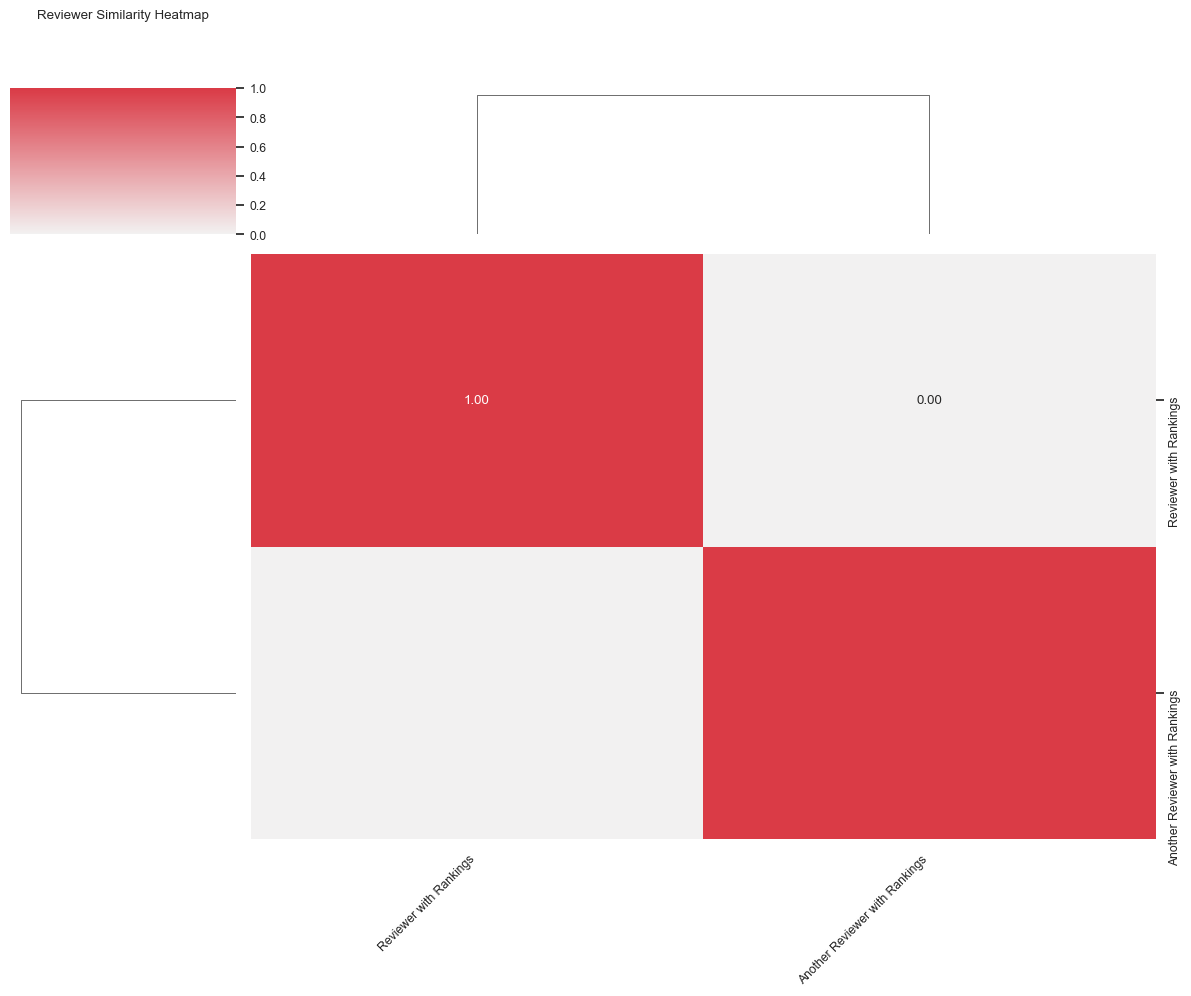

In [17]:
#from app.analysis import reviewer_similarity_heatmap

reviewer_similarity_heatmap(db, reviewer_judgment_vectors)